In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import os

# Load the dataset
data = pd.read_csv("data/monatszahlen2405_verkehrsunfaelle_export_31_05_24_r.csv", usecols=range(5))

In [28]:
data.columns = [
    "category",
    "accident_type",
    "year",
    "month",
    "value"
]

# Translate values to English to enable interpretation
category_map = {
    "Alkoholunfälle": "alcohol",
    "Fluchtunfälle": "escape",
    "Verkehrsunfälle": "traffic",
}
accident_type_map = {
    "insgesamt": "total",
    "Verletzte und Getötete": "injured_or_killed",
    "mit Personenschäden": "personal_injury",
}
data["category"] = data["category"].map(category_map)
data["accident_type"] = data["accident_type"].map(accident_type_map)

# Drop NaN values and rows with 'Summe' in the 'month' column
data.drop(index=data[data.year == 2022].index, inplace=True)  # Assuming 2022 has NaN values
data.drop(index=data[data.month == "Summe"].index, inplace=True)

# Convert 'year' and 'month' to integers and create 'date' column
data["year"] = data["year"].astype(int)
data["month"] = data["month"].astype(int).apply(lambda yearmonth: yearmonth % 100)
data["date"] = pd.to_datetime(data[["year", "month"]].assign(day=1))

# Save the cleaned data
data.to_csv("./data/en_traffic.csv", index=False)

# Copy the data for further processing
df = data.copy()

# Filter data for 'total' accident type to focus on overall accidents
df_total = df[df.accident_type == "total"]

# Get descriptive statistics grouped by 'category'
descriptive_stats = df_total.groupby("category").value.describe()
descriptive_stats

,count,mean,std,min,25%,50%,75%,max
category,,,,,,,,
alcohol,264.0,43.215909,18.066701,10.0,30.00,40.0,53.00,107.0
escape,264.0,876.859848,136.945242,411.0,791.00,873.5,966.25,1187.0
traffic,264.0,3520.250000,489.703959,2149.0,3193.75,3464.5,3890.50,4763.0


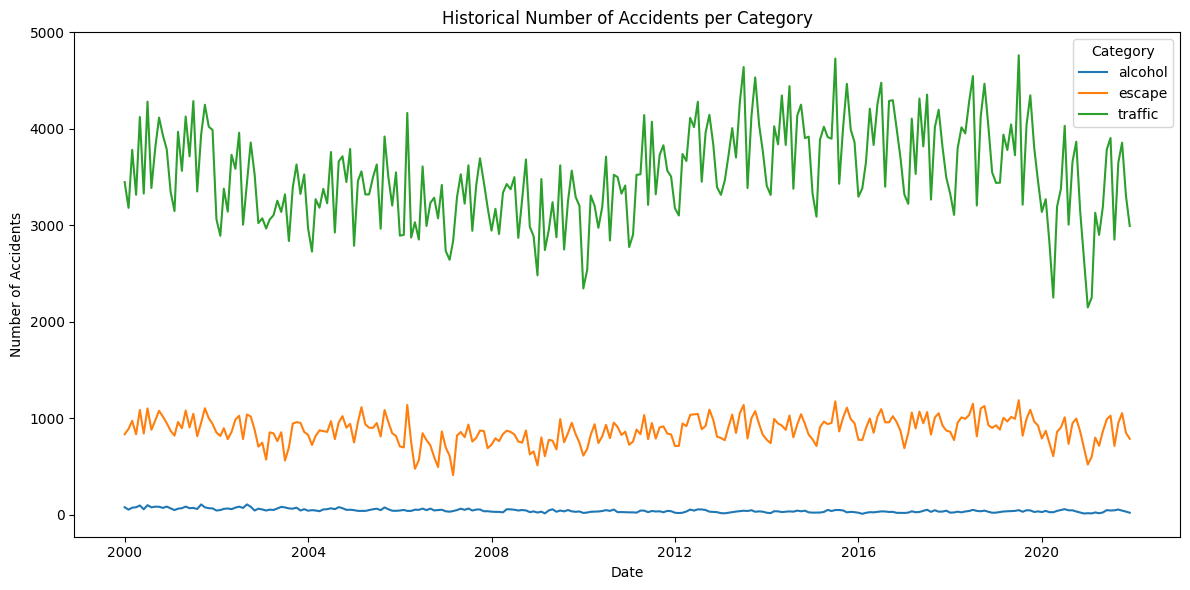

In [29]:
# Ensure the 'plots' directory exists
if not os.path.exists('plots'):
    os.makedirs('plots')

# Plot historical number of accidents per category
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_total, x="date", y="value", hue="category")
plt.title("Historical Number of Accidents per Category")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend(title='Category')
plt.tight_layout()
# Save the plot
plt.savefig('plots/historical_accidents_per_category.png')
plt.show()

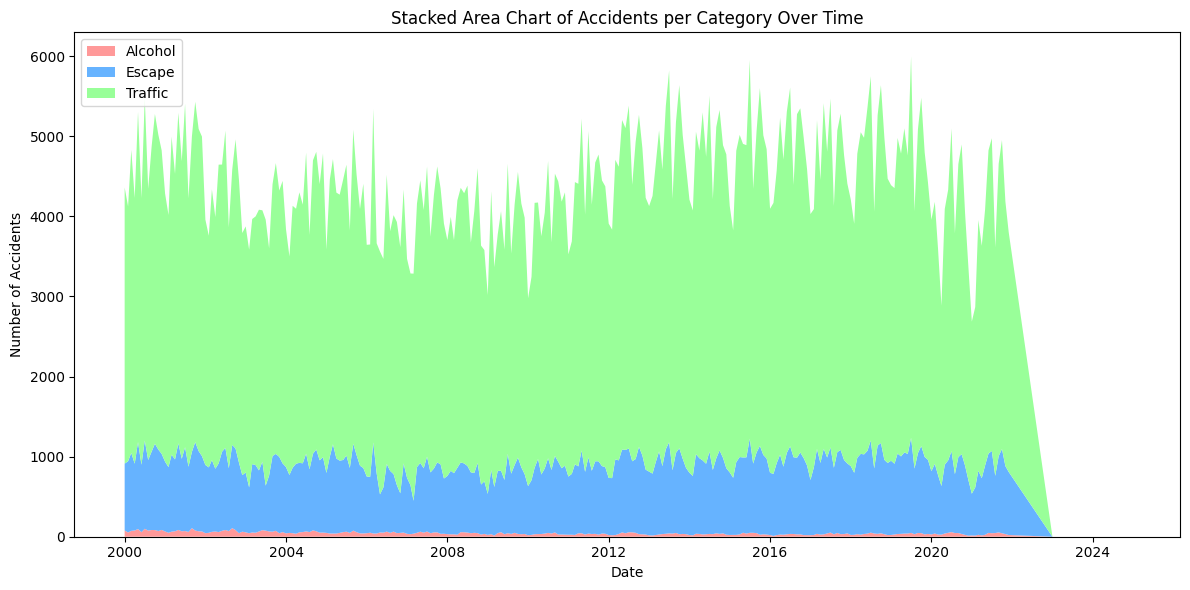

In [30]:
# Unique Change: Area Plot to Emphasize Volume of Accidents
# Pivot data to have categories as columns
pivot_df = df_total.pivot_table(values='value', index='date', columns='category', aggfunc='sum').reset_index()

# Plot stacked area chart
plt.figure(figsize=(12, 6))
plt.stackplot(pivot_df['date'], [pivot_df['alcohol'], pivot_df['escape'], pivot_df['traffic']],
              labels=['Alcohol', 'Escape', 'Traffic'], colors=['#ff9999','#66b3ff','#99ff99'])
plt.title("Stacked Area Chart of Accidents per Category Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend(loc='upper left')
plt.tight_layout()
# Save the plot
plt.savefig('plots/stacked_area_accidents_per_category.png')
plt.show()

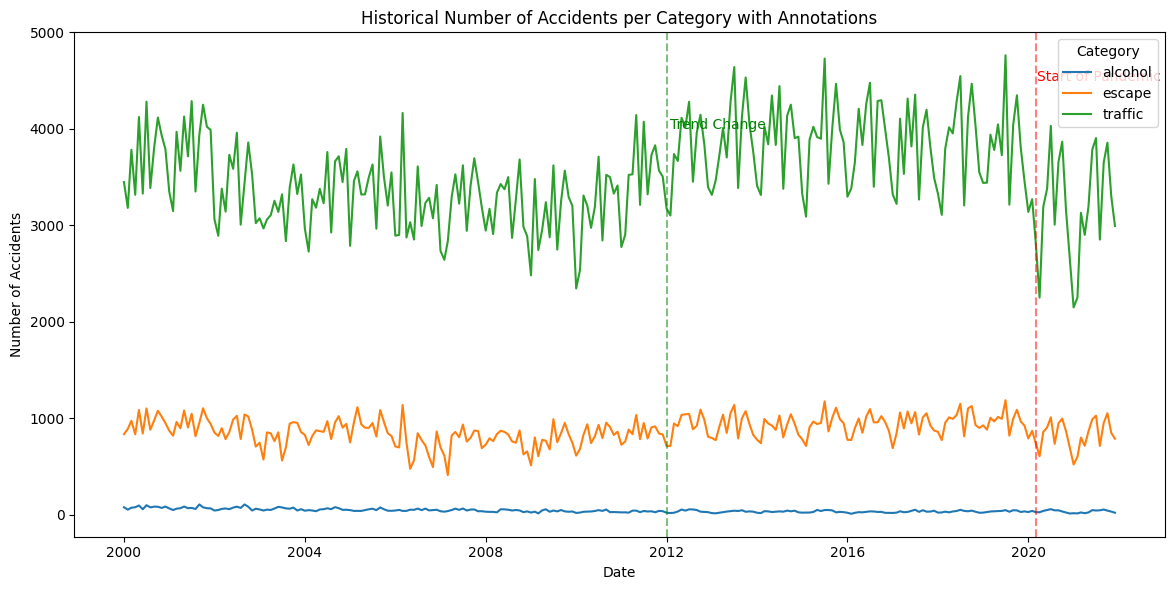

In [31]:
# Unique Change: Highlighting Significant Events
# Re-plot the line chart with annotations
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_total, x="date", y="value", hue="category")
plt.title("Historical Number of Accidents per Category with Annotations")
plt.xlabel("Date")
plt.ylabel("Number of Accidents")
plt.legend(title='Category')

# Annotate the start of the pandemic
plt.axvline(pd.to_datetime("2020-03-01"), color="red", linestyle="--", alpha=0.5)
plt.text(pd.to_datetime("2020-03-15"), plt.ylim()[1]*0.9, 'Start of Pandemic', color='red')

# Annotate a change in trend (example: 2012-01-01)
plt.axvline(pd.to_datetime("2012-01-01"), color="green", linestyle="--", alpha=0.5)
plt.text(pd.to_datetime("2012-02-01"), plt.ylim()[1]*0.8, 'Trend Change', color='green')

plt.tight_layout()
# Save the plot
plt.savefig('plots/historical_accidents_with_annotations.png')
plt.show()

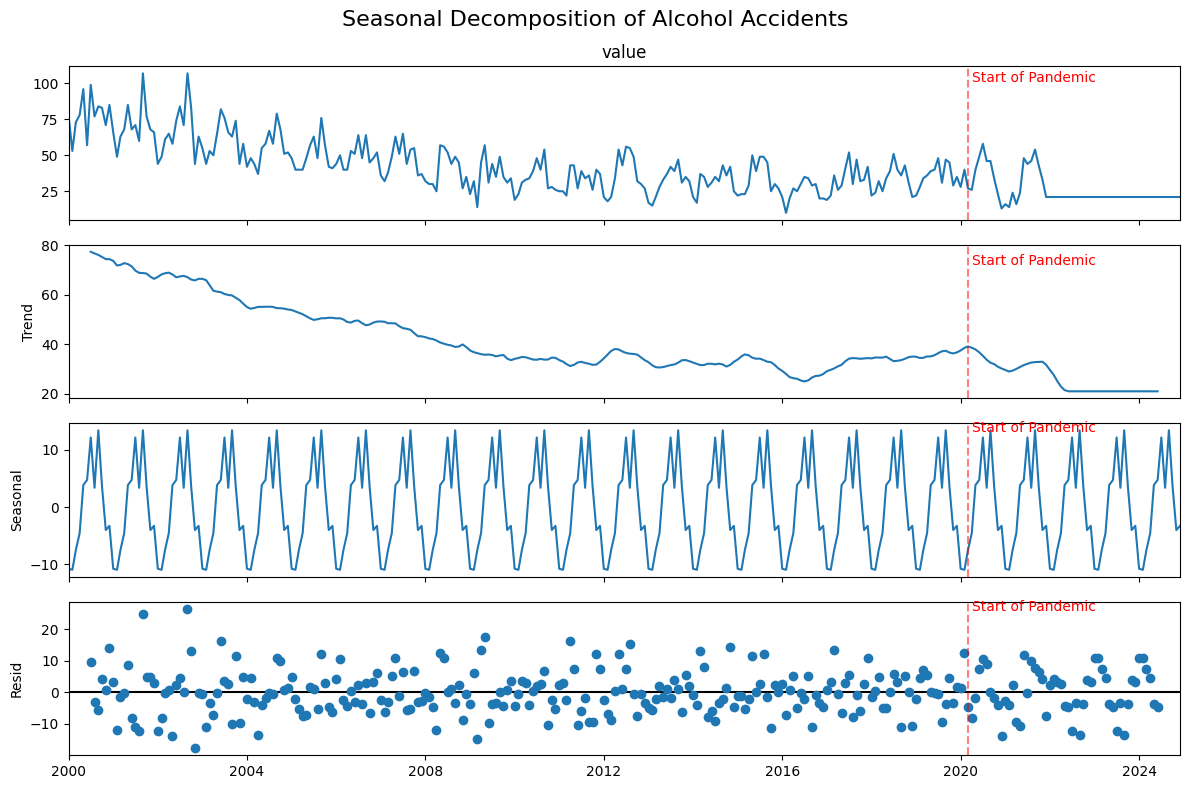

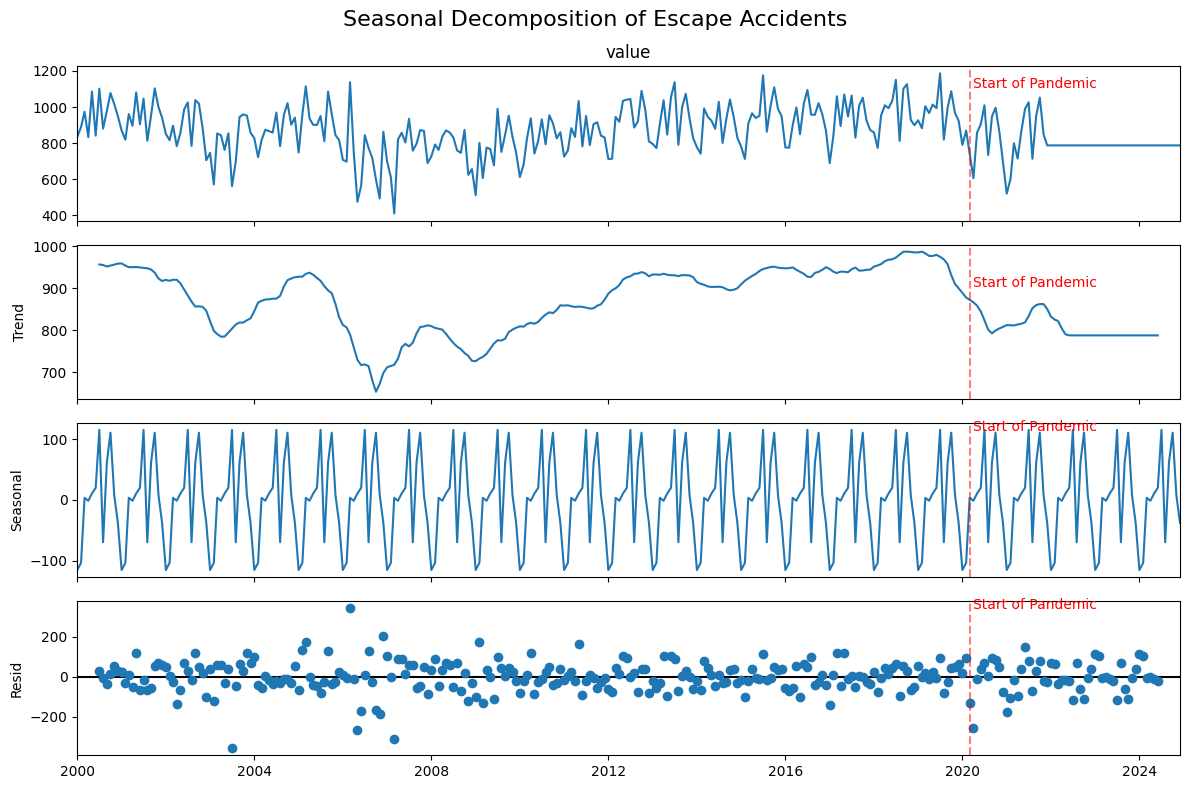

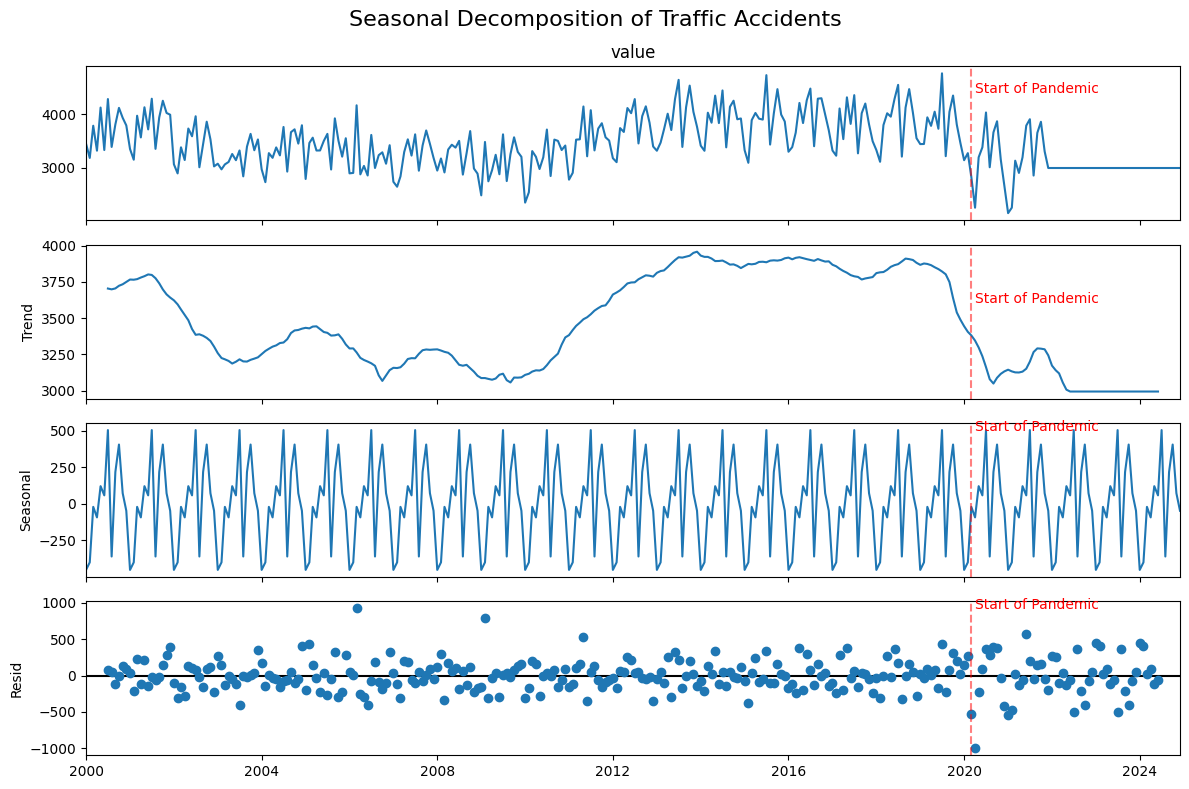

In [32]:
# Seasonal Decomposition for each category
for category in df_total['category'].unique():
    # Extract and prepare the time series
    category_series = df_total[df_total['category'] == category].set_index('date')['value'].sort_index()
    full_index = pd.date_range(start=category_series.index.min(), end=category_series.index.max(), freq='MS')
    category_series = category_series.reindex(full_index)
    category_series_interpolated = category_series.interpolate(method='time')
    
    # Proceed only if no missing values remain
    if category_series_interpolated.isnull().sum() == 0:
        decomposition = seasonal_decompose(category_series_interpolated, model="additive", period=12)
        fig = decomposition.plot()
        fig.set_size_inches(12, 8)
        fig.suptitle(f"Seasonal Decomposition of {category.capitalize()} Accidents", fontsize=16)

        # Annotate significant events
        for ax in fig.axes:
            ax.axvline(pd.to_datetime("2020-03-01"), color="red", linestyle="--", alpha=0.5)
            ax.text(pd.to_datetime("2020-04-01"), ax.get_ylim()[1]*0.9, 'Start of Pandemic', color='red')
        
        plt.tight_layout()
        # Save the plot with a filename that includes the category name
        plt.savefig(f'plots/seasonal_decomposition_{category}.png')
        plt.show()
    else:
        print(f"Unable to decompose {category} due to remaining missing values.")
